/usr/bin/python3
2021-08-13 00:00:00+00:00 2024-08-11 23:00:00+00:00


/tmp/ipykernel_2210168/3940785038.py:178: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  merged_df_1day   = merged_df1.loc[yesterday:now].copy()
/tmp/ipykernel_2210168/3940785038.py:180: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  merged_df_31days =merged_df1.loc[lastmonth:now].copy()


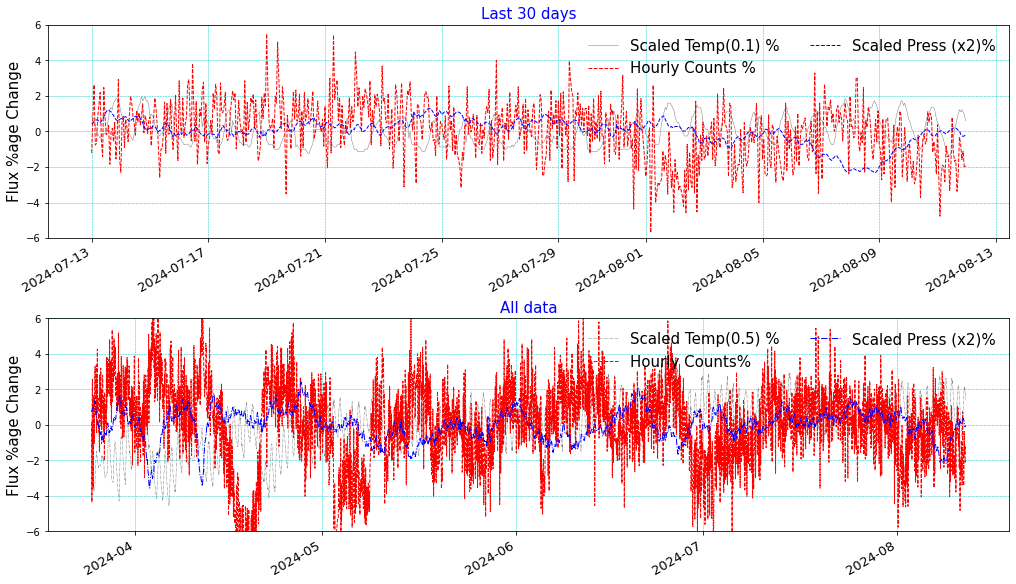

In [5]:
#importing libraries and packages
import sys,os,time
print(sys.executable)
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers
from pandas.tseries.frequencies import to_offset# needed to set the time offset to match to the muons DF
import seaborn as sns
from numpy import argmax
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder

from datetime import datetime, timedelta
def merge_tables(df1, dfpt):
    t1start=pd.Timestamp(df1.index[0])
    t1end=pd.Timestamp(df1.index[-1])
    print(t1start,t1end)
    dfpt1 = dfpt.loc[t1start:t1end].copy()
    merged_tab=pd.merge(df1,dfpt1, how='inner', left_index=True, right_index=True)
    return merged_tab

def calc_percent_change(merged_df):
    
    
    merged_df["counts_pct"] = ((merged_df['counts'] - merged_df['counts'].mean())/ 
                      merged_df['counts'].mean()*100)
    merged_df["counts_m_avg"] = merged_df.rolling('6H').counts_pct.mean()
    merged_df["press_pct"] = 2*((merged_df['mslp'] - merged_df['mslp'].mean())/ 
                      merged_df['mslp'].mean()*100)
    merged_df["temp_pct"] = ((merged_df['tmpf'] - merged_df['tmpf'].mean())/ 
                      merged_df['tmpf'].mean()*100)
    merged_df['temp_scaled'] = 0.1*merged_df['temp_pct']
    #merged_df1["delta_cts"]  = (merged_df1["counts"]-merged_df1["counts"].mean())/merged_df1["counts"]
    #merged_df1["delta_pres"] = (merged_df1["alti"]-merged_df1["alti"].mean())/merged_df1["alti"]
    merged_df["delta_cts"]  = np.log((merged_df["counts"])/merged_df["counts"].mean())
    merged_df["delta_pres"] = (merged_df["mslp"]-merged_df["mslp"].mean())
    #print(merged_df["alti"].mean(),merged_df["alti"].std(), merged_df['counts_pct'].max(), merged_df["counts"].mean(),merged_df["counts_pct"].std())
    return merged_df


# Specify the directory where your log files are stored
log_directory = '/home/cosmic/rm415'

# Get a list of all files in the directory
all_files = os.listdir(log_directory)

# Filter only files with a specific extension (e.g., '.log')
log_files = [file for file in all_files if file.endswith('.log')]

#print(log_files)

# Initialize an empty DataFrame
merged_df1 = pd.DataFrame()

# Iterate through each log file
for log_file in log_files:
    # Create the full path for the log file
    log_file_path = os.path.join(log_directory, log_file)
  
    # Read the log file into a DataFrame
    with open(log_file_path, 'r') as file:
        log_content = file.read()
        df = pd.read_csv(log_file_path, sep='\t',names=["counts"])
        
        # Merge the current DataFrame with the overall DataFrame
        merged_df1 = pd.concat([merged_df1, df], axis=0, ignore_index=True)

merged_df1= merged_df1['counts'].str.split(" ", n = 4,expand = True)
#print(merged_df)
      
# Convert the 'datetime' column to datetime format
merged_df1[4] = pd.to_datetime(merged_df1[4], errors='coerce').dt.floor('min')

# Check if there are missing values in the datetime column

# Create a continuous date-time range
date_range = pd.date_range(start=merged_df1[4].min(), end=merged_df1[4].max(), freq='1T')

complete_df = pd.DataFrame(date_range, columns=['date'])

# Step 3: Merge the complete range with the original dataframe
merged_df1 = pd.merge(complete_df, merged_df1, left_on=complete_df.columns[0], right_on=merged_df1.columns[4], how='left')


# Step 4: Identify hours with any missing data and set the entire hour's data to NaN
merged_df1['hour'] = merged_df1[4].dt.floor('H')
missing_hours = merged_df1[merged_df1[3].isna()]['date'].dt.floor('H').unique()

# Create a boolean mask to identify rows where 'hour' is in missing_hours
mask = merged_df1['hour'].isin(missing_hours)

# Set all columns except the 5th column to NaN where the mask is True
merged_df1.loc[mask, merged_df1.columns != merged_df1.columns[0]] = np.nan

# Drop the 'hour' column as it was only needed for processing
merged_df1= merged_df1.drop(columns=['hour'])
merged_df1 = merged_df1.iloc[:, :-1]


# The merged_df now contains the complete datetime range with NaNs filled for missing data
#print(merged_df1)
named_df = pd.DataFrame(merged_df1.values, columns = ["date","junk", "counts","junk1","junk2"])
named_df['counts'] = named_df['counts'].replace(',', '', regex=True)
named_df["date"]= pd.to_datetime(named_df['date'], format="%a %b %d %H:%M:%S %Y")
named_df['date'] = named_df['date'].dt.tz_localize('America/New_York',nonexistent='shift_forward')#setting current time zone
named_df['date'] = named_df['date'].dt.tz_convert('UTC')#convert time zone to UTC
named_df   = named_df.set_index('date')
#pd.to_datetime(named_df.index)
named_df["counts"] = named_df["counts"].apply(pd.to_numeric)
named_df.drop(named_df.columns[[0,2,3]],axis=1, inplace=True)

df_hourly = named_df.resample('H').sum()

df_hourly.drop(df_hourly.head(1).index,inplace=True)
df_hourly.drop(df_hourly.tail(1).index,inplace=True)


# Function to replace consecutive zeros with the average of nearest non-zero values
def replace_zeros_with_avg(df, col_name):
    zero_mask = (df[col_name] == 0)
    zero_groups = zero_mask.ne(zero_mask.shift()).cumsum()  # Create groups of consecutive zeros
    for group, values in df.loc[zero_mask, col_name].groupby(zero_groups):
        if len(values) > 0:
            before = df.loc[values.index.min() - pd.Timedelta(hours=1), col_name] if values.index.min() > df.index.min() else np.nan
            after = df.loc[values.index.max() + pd.Timedelta(hours=1), col_name] if values.index.max() < df.index.max() else np.nan
            avg = np.nanmean([before, after])
            df.loc[values.index, col_name] = avg

# Apply the function to 'counts' column
replace_zeros_with_avg(df_hourly, 'counts')




fPT1    ='mslp_temp.csv'
df1_PT  = pd.read_csv(fPT1)
df1_PT.drop(df1_PT[df1_PT['mslp'] == 'M'].index, inplace = True)
df1_PT.drop(df1_PT[df1_PT['tmpf'] == 'M'].index, inplace = True)
df1_PT.dropna(inplace=True)
df1_PT['valid'] = pd.to_datetime(df1_PT['valid'],utc=True)
df1_PT = df1_PT.set_index('valid')
df1_PT = df1_PT.drop(columns=["station"])
#print(df1_PT)
loffset = '-52min'
df1_PT.index = df1_PT.index + to_offset(loffset)
#print(df1_PT)
df1_PT["mslp"] = df1_PT["mslp"].astype(str).astype(float)
df1_PT["tmpf"] = df1_PT["tmpf"].astype(str).astype(float)
df1_PT

merged_df1= merge_tables(df1_PT,df_hourly)
#print(merged_df1)

merged_df1 = merged_df1.rename_axis('date')
merged_df1.to_csv('/home/cosmic/rm415/rm415.csv')

#plt.rcParams["axes.grid"] = True
#fig, (ax1) = plt.subplots(1,figsize=(8, 5))
#ax1.hist(merged_df1['counts'], bins=100,histtype='step',label='Counts',color='blue')
#ax1.set_title('Serbia_Det1 Counts')


from datetime import datetime, timedelta
now = datetime.utcnow().date()
yesterday = datetime.utcnow().date() - timedelta(days=1)
lastmonth = datetime.utcnow().date() - timedelta(days=31)
#print(now)
#print(yesterday)
#print(lastmonth)
#mask = (merged_df1['date'] > yesterday) & (merged_df1['date'] <= now)
#merged_df1.loc[mask]
merged_df_1day   = merged_df1.loc[yesterday:now].copy()
merged_df_1day
merged_df_31days =merged_df1.loc[lastmonth:now].copy()


merged_df=calc_percent_change(merged_df1)
calc_percent_change(merged_df_1day)
calc_percent_change(merged_df_31days)


fig = plt.figure(figsize=(14, 8),constrained_layout=True)
gs = fig.add_gridspec(2)
axs = gs.subplots(sharex=False, sharey=False)

axs[0].set_title("Last 30 days",fontsize=15,color='blue')
axs[0].plot(merged_df_31days['temp_scaled'],
linestyle='-', linewidth=0.5, color='gray', label='Scaled Temp(0.1) %')
axs[0].plot(merged_df_31days['counts_pct'],
linestyle='--', linewidth=1, color='red', label='Hourly Counts %')
axs[0].plot(merged_df_31days['press_pct'],
linestyle='--', linewidth=1, color='blue', label='Scaled Press (x2)%')

axs[1].set_title("All data",fontsize=15,color='blue')
axs[1].plot(merged_df['temp_scaled'],
            linestyle='-.', linewidth=0.5, color='gray', label='Scaled Temp(0.5) %')
axs[1].plot(merged_df["counts_pct"],
            linestyle='--', linewidth=1, color='red', label='Hourly Counts%')
axs[1].plot(merged_df["press_pct"],
            linestyle='-.', linewidth=1, color='blue', label='Scaled Press (x2)%')

axs[0].set_ylabel('Flux %age Change',fontsize=15)
axs[0].set_ylim(-6,6)
axs[0].legend(ncol=2,frameon=False,fontsize=15);
axs[0].tick_params(axis='x', labelsize=13)
axs[0].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)


axs[1].set_ylabel('Flux %age Change',fontsize=15)
axs[1].set_ylim(-6,6)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].legend(ncol=2,frameon=False,fontsize=15)
axs[1].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)

plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig('/home/cosmic/onlineMon/images/rm415_pct_Ch_mostrecent.png')
plt.show()



